In [1]:
%load_ext autoreload
%autoreload 2

In [163]:
import torch
import random
import os 
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets
from torchvision.transforms import v2
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter

from scripts import utils, predict, data_setup
from scripts.engine import train_step, test_step

from typing import List, Tuple, Dict
from tqdm.auto import tqdm
from pathlib import Path
from datetime import datetime

from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix
from PIL import Image

In [164]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [165]:
data_path = Path('data')
data_path_10_percent = data_path/'data_10_percent'
data_path_20_percent = data_path/'data_20_percent'
data_path_100_percent = data_path/'data_100_percent'
data_path_full = data_path/'food101_100_percent'

data_path_10_percent, data_path_20_percent, data_path_100_percent, data_path_full

(WindowsPath('data/data_10_percent'),
 WindowsPath('data/data_20_percent'),
 WindowsPath('data/data_100_percent'),
 WindowsPath('data/food101_100_percent'))

In [166]:
weights = models.ResNet18_Weights.DEFAULT
model = models.resnet18(weights=weights)

weights.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [167]:
summary(model=model,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

In [168]:
simple_transforms = v2.Compose([
    v2.Resize((224,224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

augmented_transforms = v2.Compose([
    v2.Resize((224,224)),
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.RandAugment(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
])

In [169]:
train_data_path_10_percent = data_path_10_percent/'train'
test_data_path_10_percent = data_path_10_percent/'test'

train_data_path_20_percent = data_path_20_percent/'train'
test_data_path_20_percent = data_path_20_percent/'test'

train_data_path_100_percent = data_path_100_percent/'train'
test_data_path_100_percent = data_path_100_percent/'test'

In [170]:
BATCH_SIZE = 32

train_dataloader_10_percent, test_dataloader_10_percent, class_list_10 = data_setup.create_dataloaders(
    train_dir=train_data_path_10_percent,
    test_dir=test_data_path_10_percent,
    transforms=simple_transforms,
    augmented=augmented_transforms,
    batch_size=BATCH_SIZE,
    num_workers=0,
)

train_dataloader_20_percent, test_dataloader_20_percent, class_list_20 = data_setup.create_dataloaders(
    train_dir=train_data_path_20_percent,
    test_dir=test_data_path_20_percent,
    transforms=simple_transforms,
    augmented=augmented_transforms,
    batch_size=BATCH_SIZE,
    num_workers=0,
)

train_dataloader_100_percent, test_dataloader_100_percent, class_list_100 = data_setup.create_dataloaders(
    train_dir=train_data_path_100_percent,
    test_dir=test_data_path_100_percent,
    transforms=simple_transforms,
    augmented=augmented_transforms,
    batch_size=BATCH_SIZE,
    num_workers=0,
)

In [171]:
train_dataset_full = datasets.Food101(root=data_path_full, split='train', transform=simple_transforms)
test_dataset_full = datasets.Food101(root=data_path_full, split='test', transform=simple_transforms)

In [172]:
train_dataloader_full = DataLoader(dataset=train_dataset_full, batch_size=32, shuffle=True, num_workers=0)
test_dataloader_full = DataLoader(dataset=test_dataset_full, batch_size=32, shuffle=False, num_workers=0)
class_list_full = train_dataset_full.classes

In [173]:
print(f"[INFO] 10 Percent DataLoader |" + "-"*50)
data_setup.info_dataloader(train_dataloader_10_percent, test_dataloader_10_percent, class_list_10)
print(f"\n[INFO] 20 Percent DataLoader |" + "-"*50)
data_setup.info_dataloader(train_dataloader_20_percent, test_dataloader_20_percent, class_list_20)
print(f"\n[INFO] 100 Percent DataLoader |" + "-"*50)
data_setup.info_dataloader(train_dataloader_100_percent, test_dataloader_100_percent, class_list_100)
print(f"\n[INFO] Full DataLoader |" + "-"*50)
data_setup.info_dataloader(train_dataloader_full, test_dataloader_full, class_list_full)

[INFO] 10 Percent DataLoader |--------------------------------------------------
Train Dataloader: Batch Size = 32 | Number of Batches = 8
Test Dataloader: Batch Size = 32 | Number of Batches = 3
Class List Length: 3

[INFO] 20 Percent DataLoader |--------------------------------------------------
Train Dataloader: Batch Size = 32 | Number of Batches = 15
Test Dataloader: Batch Size = 32 | Number of Batches = 5
Class List Length: 3

[INFO] 100 Percent DataLoader |--------------------------------------------------
Train Dataloader: Batch Size = 32 | Number of Batches = 85
Test Dataloader: Batch Size = 32 | Number of Batches = 10
Class List Length: 3

[INFO] Full DataLoader |--------------------------------------------------
Train Dataloader: Batch Size = 32 | Number of Batches = 2368
Test Dataloader: Batch Size = 32 | Number of Batches = 790
Class List Length: 101


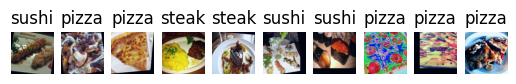

In [174]:
utils.view_dataloader_imgs(train_dataloader_10_percent, class_list_10)

In [57]:
def create_resnet(model_name=str, class_list=None):
    if model_name == "resnet18":
        weights = models.ResNet18_Weights.DEFAULT
        model = models.resnet18(weights=weights)
    else:
        weights = models.ResNet34_Weights.DEFAULT
        model = models.resnet34(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    for param in model.fc.parameters():
        param.requires_grad = True

    model.fc = nn.Linear(in_features=512, out_features=len(class_list), bias=True)
    model.name = model_name
    print(f"[INFO] Created Model - {model.name}")

    return model

In [58]:
resnet18 = create_resnet(model_name='resnet18', class_list=class_list_10)

[INFO] Created Model - resnet18


In [59]:
summary(model=resnet18,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

In [60]:
def create_writer(experiment_name: str,
                 model_name: str,
                 extra: str=None) -> torch.utils.tensorboard.SummaryWriter():

    timestamp = datetime.now().strftime("%y-%m-%d")
    if extra:
        log_dir = os.path.join("ex_runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("ex_runs", timestamp, experiment_name, model_name)

    print(f"[INFO] Creating Writer - Saved To {log_dir}")
    return SummaryWriter(log_dir=log_dir)

In [61]:
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    epochs: int,
    writer: torch.utils.tensorboard.SummaryWriter(),
):
    
    results = {"train_loss":[], "train_acc":[], "test_loss":[],"test_acc":[]}

    model.eval().to(device)
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )

        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        print(f"Epochs: {epoch+1} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Train Acc: {train_acc:.4f} | "
            f"Test Loss: {test_loss:.4f} | "
            f"Test Acc: {test_acc:.4f} ")

        if writer:
            writer.add_scalars(main_tag="Loss",
                              tag_scalar_dict={"train_loss": train_loss,
                                              "test_loss": test_loss},
                               global_step=epoch)

            writer.add_scalars(main_tag="Accuracy",
                      tag_scalar_dict={"train_acc": train_acc,
                                      "test_acc": test_acc},
                               global_step=epoch)
            writer.close()
        else:
            pass

    return results

In [75]:
epochs = [5,9]
model_list = ["resnet18", "resnet34"]
train_dataloader = {'dataloader_10_percent': train_dataloader_10_percent,
                    'dataloader_20_percent': train_dataloader_20_percent,
                    'dataloader_100_percent': train_dataloader_100_percent
                    }
test_dataloader = test_dataloader_10_percent

In [76]:
exp_track = 0

for name_dataloader, train_dataloader in train_dataloader.items(): 
    for epoch in epochs:
        for model_name in model_list:
            exp_track += 1
            print(f"[INFO] Experiment # - {exp_track}")
            print(f"[INFO] Running Config: {name_dataloader} | {model_name} | {epoch}")

            resnet = create_resnet(model_name, class_list_10)

            loss_fn=nn.CrossEntropyLoss()
            optimizer=torch.optim.SGD(resnet.parameters(), lr=0.01)

            results = train(
                model=resnet,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                device=device,
                epochs=epoch,
                writer=create_writer(experiment_name=name_dataloader,
                                     model_name=model_name,
                                     extra=f"{epoch}_epochs")
            )

            save_file_path = f"{exp_track}_{model_name}_{name_dataloader}_{epoch}_epochs.pth"
            utils.save_model(model=resnet,
                             target_dir='exp_model',
                             model_name=save_file_path
                            )
            print("-"*50 + "\n")

[INFO] Experiment # - 1
[INFO] Running Config: dataloader_10_percent | resnet18 | 5
[INFO] Created Model - resnet18
[INFO] Creating Writer - Saved To ex_runs\24-06-29\dataloader_10_percent\resnet18\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epochs: 1 | Train Loss: 1.0520 | Train Acc: 0.4805 | Test Loss: 3.0987 | Test Acc: 0.2604 
Epochs: 2 | Train Loss: 1.0596 | Train Acc: 0.6562 | Test Loss: 1.4941 | Test Acc: 0.5417 
Epochs: 3 | Train Loss: 1.0834 | Train Acc: 0.5312 | Test Loss: 1.4470 | Test Acc: 0.5417 
Epochs: 4 | Train Loss: 0.8494 | Train Acc: 0.6172 | Test Loss: 2.9222 | Test Acc: 0.1979 
Epochs: 5 | Train Loss: 0.9869 | Train Acc: 0.5547 | Test Loss: 2.5278 | Test Acc: 0.2604 
INFO: Saving Model To: exp_model\1_resnet18_dataloader_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment # - 2
[INFO] Running Config: dataloader_10_percent | resnet34 | 5
[INFO] Created Model - resnet34
[INFO] Creating Writer - Saved To ex_runs\24-06-29\dataloader_10_percent\resnet34\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epochs: 1 | Train Loss: 1.3556 | Train Acc: 0.2734 | Test Loss: 3.3321 | Test Acc: 0.2604 
Epochs: 2 | Train Loss: 1.3057 | Train Acc: 0.4844 | Test Loss: 3.1663 | Test Acc: 0.2604 
Epochs: 3 | Train Loss: 1.0192 | Train Acc: 0.7070 | Test Loss: 2.7342 | Test Acc: 0.1979 
Epochs: 4 | Train Loss: 0.8912 | Train Acc: 0.7617 | Test Loss: 1.2065 | Test Acc: 0.5521 
Epochs: 5 | Train Loss: 1.0290 | Train Acc: 0.5508 | Test Loss: 1.5104 | Test Acc: 0.5417 
INFO: Saving Model To: exp_model\2_resnet34_dataloader_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment # - 3
[INFO] Running Config: dataloader_10_percent | resnet18 | 9
[INFO] Created Model - resnet18
[INFO] Creating Writer - Saved To ex_runs\24-06-29\dataloader_10_percent\resnet18\9_epochs


  0%|          | 0/9 [00:00<?, ?it/s]

Epochs: 1 | Train Loss: 1.2116 | Train Acc: 0.3164 | Test Loss: 1.7028 | Test Acc: 0.5417 
Epochs: 2 | Train Loss: 1.2633 | Train Acc: 0.4180 | Test Loss: 3.1488 | Test Acc: 0.2604 
Epochs: 3 | Train Loss: 1.2641 | Train Acc: 0.4570 | Test Loss: 1.5414 | Test Acc: 0.5417 
Epochs: 4 | Train Loss: 1.0508 | Train Acc: 0.5859 | Test Loss: 2.5704 | Test Acc: 0.2604 
Epochs: 5 | Train Loss: 0.8436 | Train Acc: 0.6211 | Test Loss: 1.1559 | Test Acc: 0.5417 
Epochs: 6 | Train Loss: 0.9331 | Train Acc: 0.6250 | Test Loss: 1.0688 | Test Acc: 0.5625 
Epochs: 7 | Train Loss: 0.7856 | Train Acc: 0.7617 | Test Loss: 1.9985 | Test Acc: 0.2708 
Epochs: 8 | Train Loss: 0.7701 | Train Acc: 0.6641 | Test Loss: 0.9972 | Test Acc: 0.5938 
Epochs: 9 | Train Loss: 0.7093 | Train Acc: 0.6758 | Test Loss: 2.7824 | Test Acc: 0.1979 
INFO: Saving Model To: exp_model\3_resnet18_dataloader_10_percent_9_epochs.pth
--------------------------------------------------

[INFO] Experiment # - 4
[INFO] Running Config: dat

  0%|          | 0/9 [00:00<?, ?it/s]

Epochs: 1 | Train Loss: 1.0784 | Train Acc: 0.3867 | Test Loss: 3.3963 | Test Acc: 0.1979 
Epochs: 2 | Train Loss: 1.1773 | Train Acc: 0.5469 | Test Loss: 3.2389 | Test Acc: 0.2604 
Epochs: 3 | Train Loss: 1.0817 | Train Acc: 0.5234 | Test Loss: 2.6715 | Test Acc: 0.2604 
Epochs: 4 | Train Loss: 0.9612 | Train Acc: 0.7188 | Test Loss: 2.4213 | Test Acc: 0.2604 
Epochs: 5 | Train Loss: 0.8307 | Train Acc: 0.6758 | Test Loss: 2.5484 | Test Acc: 0.2083 
Epochs: 6 | Train Loss: 0.7565 | Train Acc: 0.7617 | Test Loss: 2.3379 | Test Acc: 0.2188 
Epochs: 7 | Train Loss: 0.7218 | Train Acc: 0.6953 | Test Loss: 1.2140 | Test Acc: 0.5729 
Epochs: 8 | Train Loss: 0.7420 | Train Acc: 0.6680 | Test Loss: 2.2017 | Test Acc: 0.2292 
Epochs: 9 | Train Loss: 0.7420 | Train Acc: 0.6797 | Test Loss: 1.9743 | Test Acc: 0.2595 
INFO: Saving Model To: exp_model\4_resnet34_dataloader_10_percent_9_epochs.pth
--------------------------------------------------

[INFO] Experiment # - 5
[INFO] Running Config: dat

  0%|          | 0/5 [00:00<?, ?it/s]

Epochs: 1 | Train Loss: 1.0163 | Train Acc: 0.4750 | Test Loss: 1.6035 | Test Acc: 0.3854 
Epochs: 2 | Train Loss: 0.7545 | Train Acc: 0.7312 | Test Loss: 0.8640 | Test Acc: 0.6477 
Epochs: 3 | Train Loss: 0.6402 | Train Acc: 0.7458 | Test Loss: 1.8289 | Test Acc: 0.2604 
Epochs: 4 | Train Loss: 0.6239 | Train Acc: 0.7875 | Test Loss: 0.4315 | Test Acc: 0.8854 
Epochs: 5 | Train Loss: 0.5514 | Train Acc: 0.8083 | Test Loss: 0.4114 | Test Acc: 0.8854 
INFO: Saving Model To: exp_model\5_resnet18_dataloader_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment # - 6
[INFO] Running Config: dataloader_20_percent | resnet34 | 5
[INFO] Created Model - resnet34
[INFO] Creating Writer - Saved To ex_runs\24-06-29\dataloader_20_percent\resnet34\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epochs: 1 | Train Loss: 0.9086 | Train Acc: 0.6000 | Test Loss: 0.8616 | Test Acc: 0.5360 
Epochs: 2 | Train Loss: 0.7835 | Train Acc: 0.6375 | Test Loss: 1.5738 | Test Acc: 0.4479 
Epochs: 3 | Train Loss: 0.5959 | Train Acc: 0.8146 | Test Loss: 1.0131 | Test Acc: 0.5492 
Epochs: 4 | Train Loss: 0.6057 | Train Acc: 0.7854 | Test Loss: 0.9625 | Test Acc: 0.6042 
Epochs: 5 | Train Loss: 0.6318 | Train Acc: 0.7604 | Test Loss: 2.3709 | Test Acc: 0.2188 
INFO: Saving Model To: exp_model\6_resnet34_dataloader_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment # - 7
[INFO] Running Config: dataloader_20_percent | resnet18 | 9
[INFO] Created Model - resnet18
[INFO] Creating Writer - Saved To ex_runs\24-06-29\dataloader_20_percent\resnet18\9_epochs


  0%|          | 0/9 [00:00<?, ?it/s]

Epochs: 1 | Train Loss: 1.1821 | Train Acc: 0.3438 | Test Loss: 3.1536 | Test Acc: 0.2604 
Epochs: 2 | Train Loss: 0.9713 | Train Acc: 0.6333 | Test Loss: 1.0843 | Test Acc: 0.5521 
Epochs: 3 | Train Loss: 0.7484 | Train Acc: 0.6937 | Test Loss: 2.2620 | Test Acc: 0.2604 
Epochs: 4 | Train Loss: 0.7447 | Train Acc: 0.7458 | Test Loss: 0.9685 | Test Acc: 0.5729 
Epochs: 5 | Train Loss: 0.6743 | Train Acc: 0.7375 | Test Loss: 2.5281 | Test Acc: 0.2083 
Epochs: 6 | Train Loss: 0.6006 | Train Acc: 0.7521 | Test Loss: 0.3919 | Test Acc: 0.8750 
Epochs: 7 | Train Loss: 0.4943 | Train Acc: 0.8000 | Test Loss: 0.3603 | Test Acc: 0.9072 
Epochs: 8 | Train Loss: 0.5159 | Train Acc: 0.8438 | Test Loss: 1.1768 | Test Acc: 0.4053 
Epochs: 9 | Train Loss: 0.5079 | Train Acc: 0.7958 | Test Loss: 1.5728 | Test Acc: 0.3229 
INFO: Saving Model To: exp_model\7_resnet18_dataloader_20_percent_9_epochs.pth
--------------------------------------------------

[INFO] Experiment # - 8
[INFO] Running Config: dat

  0%|          | 0/9 [00:00<?, ?it/s]

Epochs: 1 | Train Loss: 1.0843 | Train Acc: 0.4771 | Test Loss: 0.7779 | Test Acc: 0.6581 
Epochs: 2 | Train Loss: 0.7548 | Train Acc: 0.6979 | Test Loss: 1.3520 | Test Acc: 0.5417 
Epochs: 3 | Train Loss: 0.7306 | Train Acc: 0.7542 | Test Loss: 0.6375 | Test Acc: 0.7727 
Epochs: 4 | Train Loss: 0.5169 | Train Acc: 0.8146 | Test Loss: 0.9225 | Test Acc: 0.6212 
Epochs: 5 | Train Loss: 0.5333 | Train Acc: 0.7708 | Test Loss: 1.0855 | Test Acc: 0.5398 
Epochs: 6 | Train Loss: 0.5094 | Train Acc: 0.8083 | Test Loss: 0.4579 | Test Acc: 0.7623 
Epochs: 7 | Train Loss: 0.3980 | Train Acc: 0.8667 | Test Loss: 0.3091 | Test Acc: 0.9280 
Epochs: 8 | Train Loss: 0.4085 | Train Acc: 0.8583 | Test Loss: 0.3052 | Test Acc: 0.9271 
Epochs: 9 | Train Loss: 0.4339 | Train Acc: 0.8292 | Test Loss: 0.4131 | Test Acc: 0.8646 
INFO: Saving Model To: exp_model\8_resnet34_dataloader_20_percent_9_epochs.pth
--------------------------------------------------

[INFO] Experiment # - 9
[INFO] Running Config: dat

  0%|          | 0/5 [00:00<?, ?it/s]

Epochs: 1 | Train Loss: 0.6900 | Train Acc: 0.7320 | Test Loss: 0.5282 | Test Acc: 0.7339 
Epochs: 2 | Train Loss: 0.4256 | Train Acc: 0.8537 | Test Loss: 0.2786 | Test Acc: 0.9583 
Epochs: 3 | Train Loss: 0.3724 | Train Acc: 0.8707 | Test Loss: 0.2594 | Test Acc: 0.9072 
Epochs: 4 | Train Loss: 0.3462 | Train Acc: 0.8717 | Test Loss: 0.3170 | Test Acc: 0.8665 
Epochs: 5 | Train Loss: 0.3255 | Train Acc: 0.8814 | Test Loss: 0.2274 | Test Acc: 0.9176 
INFO: Saving Model To: exp_model\9_resnet18_dataloader_100_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment # - 10
[INFO] Running Config: dataloader_100_percent | resnet34 | 5
[INFO] Created Model - resnet34
[INFO] Creating Writer - Saved To ex_runs\24-06-29\dataloader_100_percent\resnet34\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epochs: 1 | Train Loss: 0.6459 | Train Acc: 0.7284 | Test Loss: 0.3371 | Test Acc: 0.9384 
Epochs: 2 | Train Loss: 0.4001 | Train Acc: 0.8520 | Test Loss: 0.2143 | Test Acc: 0.9384 
Epochs: 3 | Train Loss: 0.3467 | Train Acc: 0.8737 | Test Loss: 0.1976 | Test Acc: 0.9384 
Epochs: 4 | Train Loss: 0.3134 | Train Acc: 0.8835 | Test Loss: 0.3202 | Test Acc: 0.9081 
Epochs: 5 | Train Loss: 0.3006 | Train Acc: 0.8917 | Test Loss: 0.1924 | Test Acc: 0.9489 
INFO: Saving Model To: exp_model\10_resnet34_dataloader_100_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment # - 11
[INFO] Running Config: dataloader_100_percent | resnet18 | 9
[INFO] Created Model - resnet18
[INFO] Creating Writer - Saved To ex_runs\24-06-29\dataloader_100_percent\resnet18\9_epochs


  0%|          | 0/9 [00:00<?, ?it/s]

Epochs: 1 | Train Loss: 0.6740 | Train Acc: 0.7360 | Test Loss: 0.3169 | Test Acc: 0.9167 
Epochs: 2 | Train Loss: 0.4312 | Train Acc: 0.8438 | Test Loss: 0.2586 | Test Acc: 0.9167 
Epochs: 3 | Train Loss: 0.3822 | Train Acc: 0.8533 | Test Loss: 0.2976 | Test Acc: 0.8769 
Epochs: 4 | Train Loss: 0.3492 | Train Acc: 0.8784 | Test Loss: 0.2169 | Test Acc: 0.9280 
Epochs: 5 | Train Loss: 0.3219 | Train Acc: 0.8830 | Test Loss: 0.1997 | Test Acc: 0.9583 
Epochs: 6 | Train Loss: 0.3190 | Train Acc: 0.8844 | Test Loss: 0.2550 | Test Acc: 0.8769 
Epochs: 7 | Train Loss: 0.3002 | Train Acc: 0.8960 | Test Loss: 0.2171 | Test Acc: 0.9479 
Epochs: 8 | Train Loss: 0.2986 | Train Acc: 0.8858 | Test Loss: 0.2035 | Test Acc: 0.9176 
Epochs: 9 | Train Loss: 0.2914 | Train Acc: 0.8955 | Test Loss: 0.3287 | Test Acc: 0.8769 
INFO: Saving Model To: exp_model\11_resnet18_dataloader_100_percent_9_epochs.pth
--------------------------------------------------

[INFO] Experiment # - 12
[INFO] Running Config: 

  0%|          | 0/9 [00:00<?, ?it/s]

Epochs: 1 | Train Loss: 0.6201 | Train Acc: 0.7560 | Test Loss: 0.2981 | Test Acc: 0.9280 
Epochs: 2 | Train Loss: 0.3923 | Train Acc: 0.8635 | Test Loss: 0.2264 | Test Acc: 0.9384 
Epochs: 3 | Train Loss: 0.3492 | Train Acc: 0.8766 | Test Loss: 0.1849 | Test Acc: 0.9384 
Epochs: 4 | Train Loss: 0.3195 | Train Acc: 0.8822 | Test Loss: 0.2243 | Test Acc: 0.9384 
Epochs: 5 | Train Loss: 0.3003 | Train Acc: 0.8931 | Test Loss: 0.1584 | Test Acc: 0.9688 
Epochs: 6 | Train Loss: 0.2852 | Train Acc: 0.8969 | Test Loss: 0.1509 | Test Acc: 0.9688 
Epochs: 7 | Train Loss: 0.2859 | Train Acc: 0.8926 | Test Loss: 0.2875 | Test Acc: 0.9280 
Epochs: 8 | Train Loss: 0.2879 | Train Acc: 0.8955 | Test Loss: 0.1823 | Test Acc: 0.9384 
Epochs: 9 | Train Loss: 0.2625 | Train Acc: 0.9081 | Test Loss: 0.1650 | Test Acc: 0.9384 
INFO: Saving Model To: exp_model\12_resnet34_dataloader_100_percent_9_epochs.pth
--------------------------------------------------



In [66]:
!taskkill /IM "tensorboard.exe" /F
!rmdir /S /Q %temp%\.tensorboard-info

SUCCESS: The process "tensorboard.exe" with PID 22444 has been terminated.


In [67]:
%load_ext tensorboard
%tensorboard --logdir ex_runs --host=127.0.0.1 --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
